*Maestría de Ciencia de Datos - UNAJ*

# Trabajo Final: Aplicaciones de Ciencia de datos

*Febrero 2026*

## Integrantes
- Raul Burgos
- Mauro Cejas Marcovecchio
- Raul Muñoz
- Mirta Soto

## Descripción

El objetivo del siguiente trabajo es el análisis exploratorio, preprocesamiento de datos y el desarrollo de modelos de machine
learning sobre el dataset provisto por el Sistema de Información y Gestión Agrometeorológica (SIGA), del [Instituto Nacional de Tecnología Agropecuaria (INTA)](https://siga.inta.gob.ar/). Esta base de datos contiene información agrometeorológica de la Provincia de Corrientes, Argentina.


## EDA y Preprocesamiento

### Preprocesamiento básico y limpieza inicial

In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Primero que nada, tenemos que importar al entorno los tres archivos provistos.
# Debido a que se trata de archivos .xls, tenemos que utilizar el engine 'xlrd' al momento de importarlos.
# El problema es que la librería xlrd ya no soporta archivos xls a partir de su versión 2.0.1
# Por lo tanto, deberíamos crear un entorno virtual con una versión anterior de xlrd (1.2.0)
# De todas formas, vamos a optar por el camino más sencillo, que es guardar los archivos en formato .xlsx manualmente y luego importarlos.

dataset1 = pd.read_excel('data/A872950.xlsx')
dataset2 = pd.read_excel('data/A872951.xlsx')
dataset3 = pd.read_excel('data/A872952.xlsx')

In [3]:
# Con shape vamos a comprobar que los datasets tienen la misma cantidad de dimensiones.

print("Dimensiones:", dataset1.shape)
print("Dimensiones:", dataset2.shape)
print("Dimensiones:", dataset3.shape)

Dimensiones: (3939, 30)
Dimensiones: (3714, 30)
Dimensiones: (2220, 30)


In [4]:
# Mediante columns vamos a poder ver que las tres tablas tienen las mismas columnas y tipos de datos.
# Por lo tanto, podemos proceder a unificarlas en un solo dataset.

print(
    pd.DataFrame({
        "dataset1": dataset1.columns,
        "dataset2": dataset2.columns,
        "dataset3": dataset3.columns
    })
)

                               dataset1                             dataset2  \
0                                 Fecha                                Fecha   
1              Temperatura_Abrigo_150cm             Temperatura_Abrigo_150cm   
2       Temperatura_Abrigo_150cm_Maxima      Temperatura_Abrigo_150cm_Maxima   
3       Temperatura_Abrigo_150cm_Minima      Temperatura_Abrigo_150cm_Minima   
4     Temperatura_Intemperie_5cm_Minima    Temperatura_Intemperie_5cm_Minima   
5    Temperatura_Intemperie_50cm_Minima   Temperatura_Intemperie_50cm_Minima   
6           Temperatura_Suelo_5cm_Media          Temperatura_Suelo_5cm_Media   
7          Temperatura_Suelo_10cm_Media         Temperatura_Suelo_10cm_Media   
8                  Temperatura_Inte_5cm                 Temperatura_Inte_5cm   
9   Temperatura_Intemperie_150cm_Minima  Temperatura_Intemperie_150cm_Minima   
10                        Humedad_Suelo                        Humedad_Suelo   
11          Precipitacion_Pluviometrica 

In [5]:
# Antes de consolidar la información, vamos a incorporar la ubicación geográfica de cada estación meteorológica.
# Esto lo hacemos agregando tres columnas nuevas: 'Latitud', 'Longitud' y 'Localidad'

dataset1['Latitud'] = -29.1784992218018
dataset1['Longitud'] = -59.0923004150391
dataset1['Localidad'] = 'Goya' 

dataset2['Latitud'] = -28.452600479126
dataset2['Longitud'] = -58.9865989685059
dataset2['Localidad'] = 'Bella Vista'

dataset3['Latitud'] = -27.6566638946533
dataset3['Longitud'] = -58.2937927246094
dataset3['Localidad'] = 'Herliszka'

In [6]:
df = pd.concat([dataset1, dataset2, dataset3], ignore_index=True)

#### Cantidad de registros y variables

Tal como podemos observar mediante la descripción del dataset que aglutina a los tres archivos, disponemos de un total de 9873 registros y 33 variables. 

De todas formas, aquellas variables vinculadas a la medición de la temperatura a la intemperie y el suelo a 5 cm, como también la humedad del suelo, no tendrán valores válidos. Por lo tanto, las quitaremos del dataset utilizado, junto a las variables vinculadas a la Heliofanía. La mayoría de estas variables serán de tipo numérico, a excepción de las vinculadas a la dirección del viento, la ubicación y la fecha, cuyo tipo deberemos corregir.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9873 entries, 0 to 9872
Data columns (total 33 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Fecha                                9873 non-null   object 
 1   Temperatura_Abrigo_150cm             9508 non-null   float64
 2   Temperatura_Abrigo_150cm_Maxima      9493 non-null   float64
 3   Temperatura_Abrigo_150cm_Minima      9487 non-null   float64
 4   Temperatura_Intemperie_5cm_Minima    0 non-null      float64
 5   Temperatura_Intemperie_50cm_Minima   1404 non-null   float64
 6   Temperatura_Suelo_5cm_Media          0 non-null      float64
 7   Temperatura_Suelo_10cm_Media         9116 non-null   float64
 8   Temperatura_Inte_5cm                 0 non-null      float64
 9   Temperatura_Intemperie_150cm_Minima  1412 non-null   float64
 10  Humedad_Suelo                        0 non-null      float64
 11  Precipitacion_Pluviometrica   

In [8]:
df = df.dropna(axis = 1, how = 'all')
df = df.drop(columns = ['Heliofania_Efectiva', 'Heliofania_Relativa'])

# Vamos a convertir la columna 'Fecha' en un objeto datetime, para facilitar su manipulación posterior.
df['Fecha'] = pd.to_datetime(df['Fecha'])

A su vez, resulta interesante notar que los valores de la categoría referida a la dirección del viento a 1000 cm son nulos o una 'C'. Ésto es diferente a lo que ocurre en el caso de esta misma medición a 200 cm, que correctamente integra los distintos puntos cardinales. Más allá de suponer que la 'C' significa viento 'calmo' y, considerando que el 97% de los valores de esa categoría toman el mismo valor, procederemos a dejarla de lado.

In [9]:
print(df['Direccion_Viento_200cm'].unique())
print(df['Direccion_Viento_1000cm'].unique())

['  ' 'C ' 'S ' 'W ' 'E ' 'SE' 'NE' 'N ' 'NW']
['  ' 'C ']


In [10]:
df = df.drop(columns=['Direccion_Viento_1000cm'])

Por último, viendo que las Temperaturas a la Intemperie a 50 y 150 cm Mínimas tienen aproximadamente el 85% de valores faltantes, vamos a descartarlas también.

In [11]:
df = df.drop(columns=['Temperatura_Intemperie_50cm_Minima', 'Temperatura_Intemperie_150cm_Minima'])


#### Tipos de variables

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9873 entries, 0 to 9872
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Fecha                            9873 non-null   datetime64[ns]
 1   Temperatura_Abrigo_150cm         9508 non-null   float64       
 2   Temperatura_Abrigo_150cm_Maxima  9493 non-null   float64       
 3   Temperatura_Abrigo_150cm_Minima  9487 non-null   float64       
 4   Temperatura_Suelo_10cm_Media     9116 non-null   float64       
 5   Precipitacion_Pluviometrica      9149 non-null   float64       
 6   Precipitacion_Cronologica        9129 non-null   float64       
 7   Precipitacion_Maxima_30minutos   8324 non-null   float64       
 8   Tesion_Vapor_Media               9437 non-null   float64       
 9   Humedad_Media                    9502 non-null   float64       
 10  Humedad_Media_8_14_20            9475 non-null   float64    

In [13]:
df.head()

,Fecha,Temperatura_Abrigo_150cm,Temperatura_Abrigo_150cm_Maxima,Temperatura_Abrigo_150cm_Minima,Temperatura_Suelo_10cm_Media,Precipitacion_Pluviometrica,Precipitacion_Cronologica,Precipitacion_Maxima_30minutos,Tesion_Vapor_Media,Humedad_Media,...,Direccion_Viento_200cm,Velocidad_Viento_1000cm_Media,Velocidad_Viento_Maxima,Presion_Media,Radiacion_Global,Horas_Frio,Unidades_Frio,Latitud,Longitud,Localidad
0,2013-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,NaN,NaN,NaN,NaN,NaN,NaN,-29.178499,-59.0923,Goya
1,2013-09-04,13.49305,23.5,5.4,17.35556,0.0,0.0,0.0,8.78381,60.0,...,C,NaN,NaN,NaN,NaN,3.153999,0.498000,-29.178499,-59.0923,Goya
2,2013-09-05,17.53334,28.9,9.7,18.86459,0.0,0.0,0.0,11.46247,58.0,...,C,NaN,NaN,NaN,NaN,0.000000,-9.129999,-29.178499,-59.0923,Goya
3,2013-09-06,22.60834,34.1,13.8,21.49792,0.0,0.0,0.0,17.97431,64.0,...,C,NaN,NaN,NaN,NaN,0.000000,-16.849020,-29.178499,-59.0923,Goya
4,2013-09-07,26.51389,36.3,20.3,23.58055,0.0,0.0,0.0,18.40356,55.0,...,C,NaN,NaN,NaN,NaN,0.000000,-23.904030,-29.178499,-59.0923,Goya


#### Valores faltantes, duplicados e inconsistencias

In [14]:
print("Valores faltantes por columna:")
print(df.isnull().sum().sort_values(ascending=False))

Valores faltantes por columna:
Precipitacion_Maxima_30minutos     1549
Rocio_Medio                        1119
Velocidad_Viento_200cm_Media        875
Velocidad_Viento_1000cm_Media       875
Duracion_Follaje_Mojado             832
Radiacion_Global                    832
Presion_Media                       832
Velocidad_Viento_Maxima             824
Temperatura_Suelo_10cm_Media        757
Precipitacion_Cronologica           744
Precipitacion_Pluviometrica         724
Horas_Frio                          447
Unidades_Frio                       446
Tesion_Vapor_Media                  436
Humedad_Media_8_14_20               398
Temperatura_Abrigo_150cm_Minima     386
Temperatura_Abrigo_150cm_Maxima     380
Humedad_Media                       371
Temperatura_Abrigo_150cm            365
Longitud                              0
Latitud                               0
Fecha                                 0
Direccion_Viento_200cm                0
Localidad                             0
dtype: in

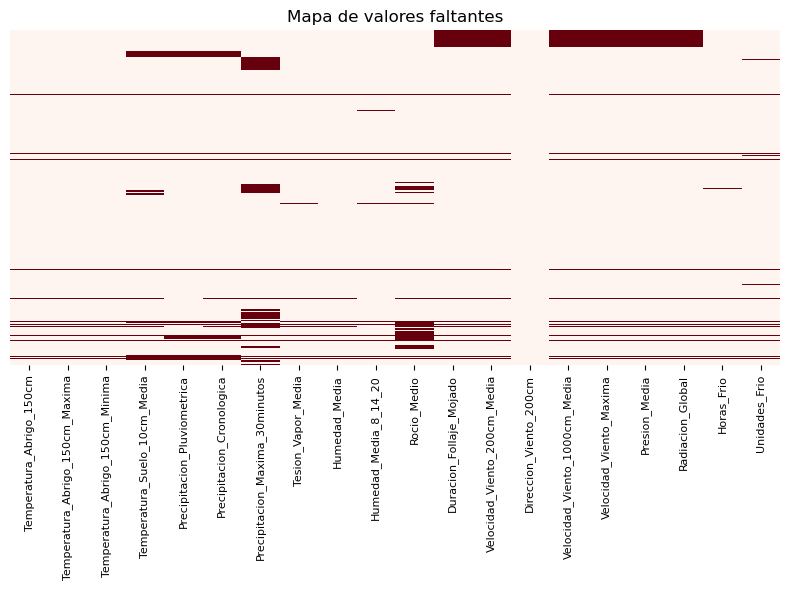

In [15]:
# Visualización simple de patrón de faltantes

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    df.drop(columns = ['Fecha', 'Latitud', 'Longitud', 'Localidad']).isnull(), 
            cbar = False, 
            cmap = 'Reds')
plt.title('Mapa de valores faltantes')
plt.ylabel('')
plt.yticks([])
plt.xticks(fontsize = 8)
plt.tight_layout()
plt.show()


# Hay muchas filas en las que se encuentran faltantes en todas las columnas menos la Dirección del viento.
# Encontrar la forma de descartarlas

In [16]:
print("Filas duplicadas:")
print(df.duplicated().sum())

Filas duplicadas:
0


#### Valores atípicos

Vamos a utilizar dos métodos gráficos para la detección de outliers:
- Diagramas de cajas y bigotes
- Diagramas de dispersión

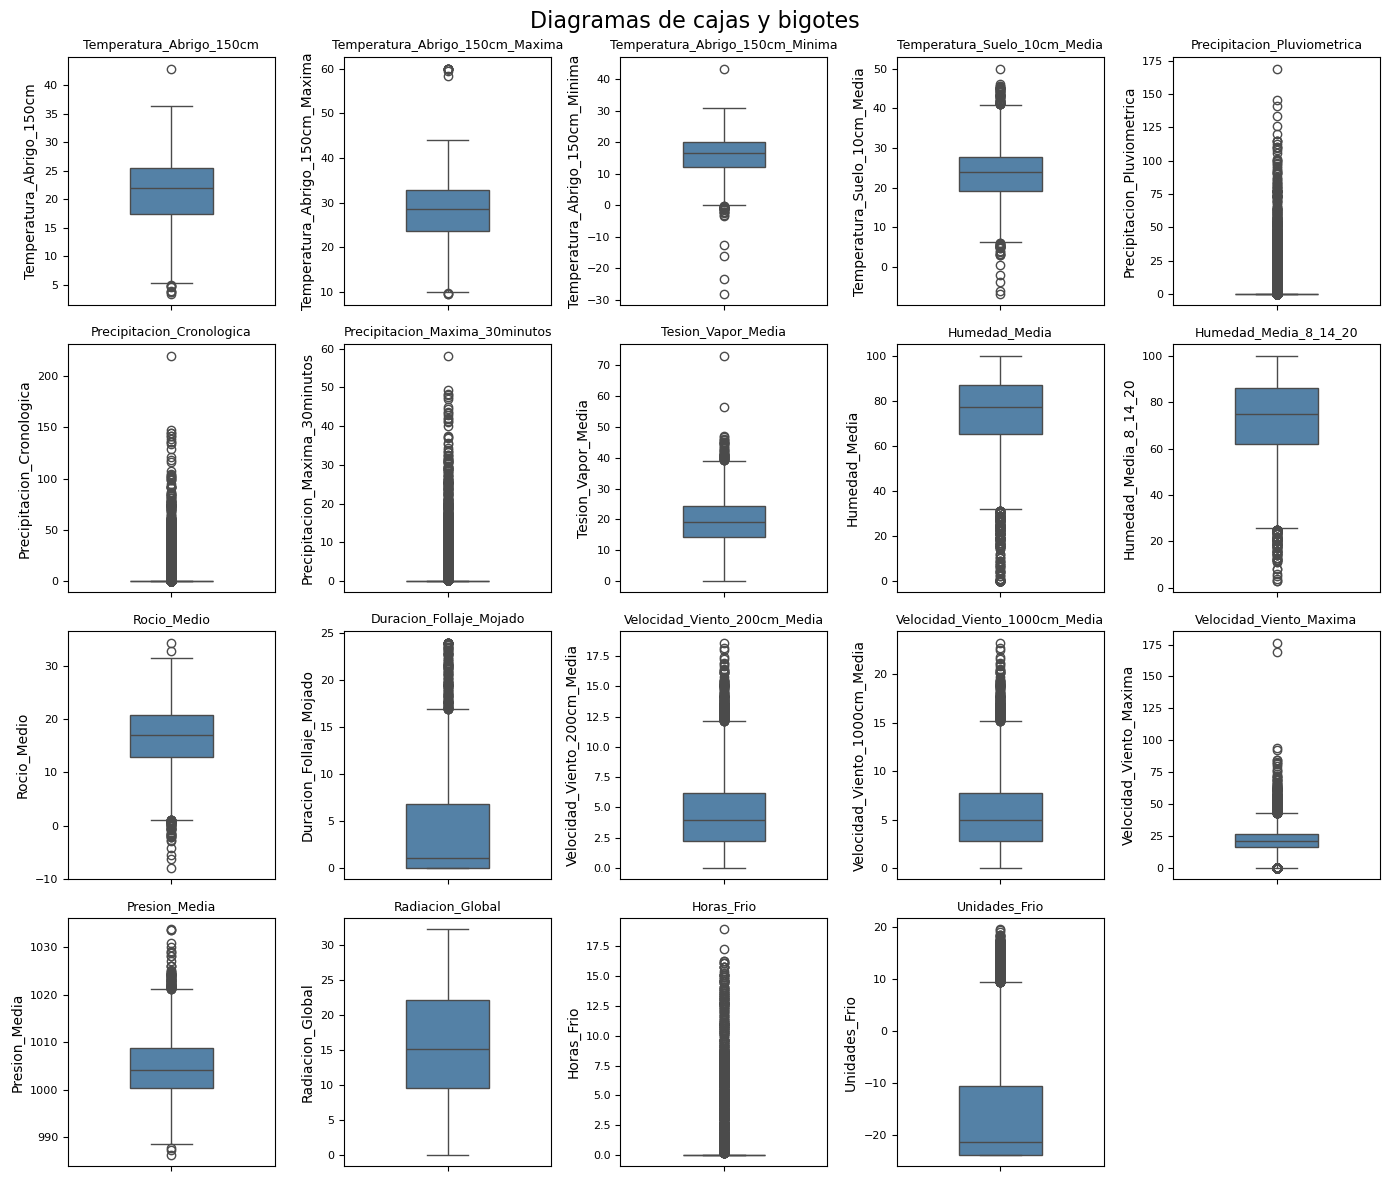

In [27]:
variables = df.drop(columns = ['Fecha', 'Latitud', 'Longitud', 'Localidad', 'Direccion_Viento_200cm']).columns

n_cols = 5
n_rows = 4

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize = (14, 12),
    sharey = False)

fig.suptitle('Diagramas de cajas y bigotes', fontsize = 16)

axes = axes.flatten()

for i, var in enumerate(variables):
    sns.boxplot(
        y = df[var],
        ax = axes[i],
        color = 'steelblue',
        width = 0.4
    )
    axes[i].set_title(var, fontsize = 9)
    axes[i].set_xlabel('')
    axes[i].tick_params(axis = 'y', labelsize = 8)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

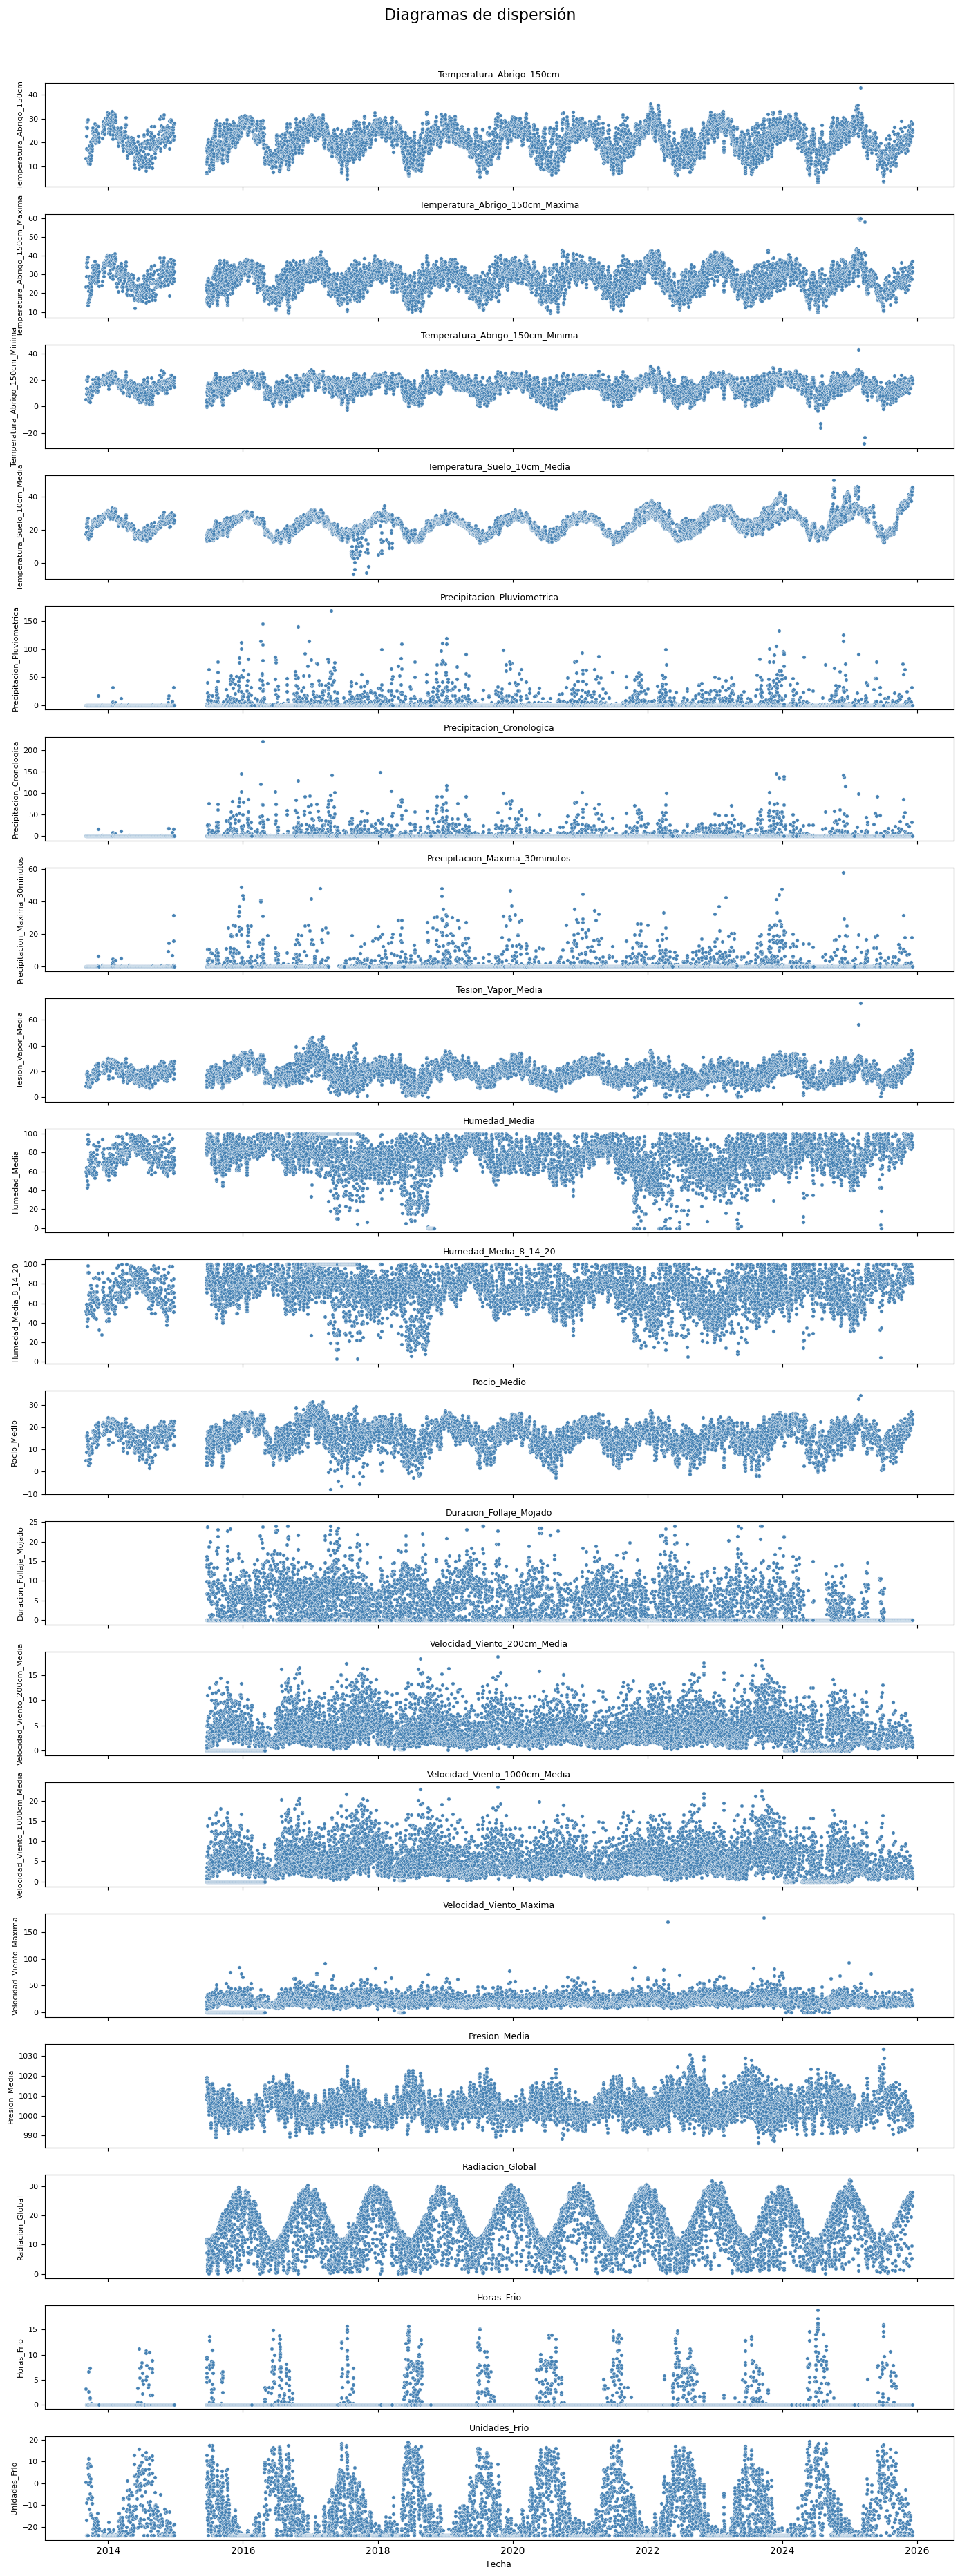

In [30]:
variables = df.drop(columns = ['Fecha', 'Latitud', 'Longitud', 'Localidad', 'Direccion_Viento_200cm']).columns

n_cols = 1
n_rows = 19

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize = (14, 38),
    sharex = True)

fig.suptitle('Diagramas de dispersión', fontsize = 16)

axes = axes.flatten()

for i, var in enumerate(variables):
    sns.scatterplot(
        x = df['Fecha'],
        y = df[var],
        ax = axes[i],
        s = 15,
        #alpha = 0.4,
        color = 'steelblue',
    )
    axes[i].set_title(var, fontsize = 9)
    axes[i].set_ylabel(var, fontsize=8)
    axes[i].tick_params(axis = 'y', labelsize = 8)

axes[-1].set_xlabel('Fecha', fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### Resumen estadístico

In [31]:
# Obtener las principales medidas de posición y de dispersión de cada variable.

display(df.drop(columns=['Fecha', 'Latitud', 'Longitud']).describe().round(2))

,Temperatura_Abrigo_150cm,Temperatura_Abrigo_150cm_Maxima,Temperatura_Abrigo_150cm_Minima,Temperatura_Suelo_10cm_Media,Precipitacion_Pluviometrica,Precipitacion_Cronologica,Precipitacion_Maxima_30minutos,Tesion_Vapor_Media,Humedad_Media,Humedad_Media_8_14_20,Rocio_Medio,Duracion_Follaje_Mojado,Velocidad_Viento_200cm_Media,Velocidad_Viento_1000cm_Media,Velocidad_Viento_Maxima,Presion_Media,Radiacion_Global,Horas_Frio,Unidades_Frio
count,9508.00,9493.00,9487.00,9116.00,9149.00,9129.00,8324.00,9437.00,9502.00,9475.00,8754.00,9041.00,8998.00,8998.00,9049.00,9041.00,9041.00,9426.00,9427.00
mean,21.29,27.99,15.90,23.69,3.01,3.02,1.19,19.44,74.71,73.17,16.48,3.57,4.48,5.60,22.07,1004.73,15.51,0.53,-15.87
std,5.62,6.38,5.75,5.83,11.22,11.65,4.36,6.84,17.39,17.09,5.58,4.58,3.04,3.80,10.14,6.12,7.86,2.07,10.68
min,3.41,9.50,-28.10,-6.80,0.00,0.00,0.00,0.01,0.00,3.00,-7.96,0.00,0.00,0.00,0.00,986.28,0.02,0.00,-23.90
25%,17.36,23.60,12.10,19.16,0.00,0.00,0.00,14.45,65.00,62.00,12.85,0.00,2.22,2.78,16.10,1000.38,9.59,0.00,-23.90
50%,21.94,28.50,16.70,23.94,0.00,0.00,0.00,19.22,77.00,75.00,17.07,1.08,3.95,4.94,20.70,1004.11,15.17,0.00,-21.33
75%,25.55,32.70,20.20,27.85,0.00,0.00,0.00,24.23,87.00,86.00,20.69,6.77,6.19,7.74,26.80,1008.71,22.14,0.00,-10.62
max,42.96,60.00,43.30,50.00,169.00,220.00,58.20,73.20,100.00,100.00,34.39,24.00,18.63,23.29,176.60,1033.71,32.27,18.92,19.51


### Visualizaciones: análisis univariado, bivariado y multivariado

In [ ]:
df_pairplot = df.drop(columns=['Latitud', 'Longitud', 'Localidad', 'Direccion_Viento_200cm'])

for grupo in grupos:

    sns.pairplot(
        df_pairplot,
        x_vars = grupo,
        y_vars = "Radiacion_Global",
        height = 3,
        aspect = 1.2
    )

    plt.show()


### Preprocesamiento y limpieza avanzada de datos.

### Conclusiones parciales

In [ ]:
# Elaborar conclusiones parciales que sinteticen los principales hallazgos del análisis
# exploratorio y las decisiones de preprocesamiento adoptadas.

## Modelado, Evaluación e Interpretabilidad

### Selección de modelos

Seleccionar al menos dos algoritmos de machine learning adecuados para el problema
planteado y justificar su elección.

### Entrenamiento, validación y optimización de modelos

Realizar el entrenamiento de los modelos seleccionados, incorporando técnicas de
validación cruzada (cross-validation) y la optimización de hiperparámetros mediante algún
método de búsqueda (por ejemplo, Grid Search, Random Search u otros).

Describir el esquema de validación utilizado y los principales hiperparámetros optimizados.

### Evaluación y análisis de resultados

Evaluar y comparar el desempeño de los modelos utilizando métricas adecuadas para el
problema.

Visualizar y analizar el output de los modelos, incluyendo comparaciones entre valores
reales y predichos sobre el conjunto de test.

Detallar y representar gráficamente la “confianza” o incertidumbre asociada a las
predicciones, cuando corresponda.

### Interpretabilidad de los modelos

Realizar un análisis de interpretabilidad de los modelos entrenados, identificando las variables
más relevantes y discutiendo su impacto en las predicciones.

### Conclusiones

Elaborar conclusiones integradoras a partir de los resultados obtenidos, destacando
fortalezas, limitaciones y posibles mejoras
